In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap

import datetime
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

from matplotlib.animation import ArtistAnimation

plt.style.use('default')

CONFIRMED_CASES_TIME_SERIES_CSV = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
DEATH_CASES_TIME_SERIES_CSV = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
RECOVERED_CASES_TIME_SERIES_CSV = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# needed to know the latest column in the timeseries
first_date = datetime.date(2020, 1, 22)
yesterday = (datetime.datetime.today() - datetime.timedelta(days=1)).date()
latest_column_name = yesterday.strftime('%-m/%-d/%y')


In [145]:
confirmed_cases_timeseries = pd.read_csv(CONFIRMED_CASES_TIME_SERIES_CSV)
death_cases_timeseries = pd.read_csv(DEATH_CASES_TIME_SERIES_CSV)
recovered_cases_timeseries = pd.read_csv(RECOVERED_CASES_TIME_SERIES_CSV)

confirmed_cases_timeseries

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
0               NaN       Thailand  15.0000  101.0000        2        3   
1               NaN          Japan  36.0000  138.0000        2        1   
2               NaN      Singapore   1.2833  103.8333        0        1   
3               NaN          Nepal  28.1667   84.2500        0        0   
4               NaN       Malaysia   2.5000  112.5000        0        0   
..              ...            ...      ...       ...      ...      ...   
399     Socorro, NM             US  33.8837 -106.7235        0        0   
400  Bernalillo, NM             US  35.0178 -106.6291        0        0   
401     Oakland, MI             US  42.5922  -83.3362        0        0   
402       Wayne, MI             US  42.2791  -83.3362        0        0   
403  New Castle, DE             US  39.5393  -75.6674        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  3/2/20  3/3/20  3/4/20  3/5/20  \
0          5        7        8        8  ...      43      43      43      47   
1          2        2        4        4  ...     274     293     331     360   
2          3        3        4        5  ...     108     110     110     117   
3          0        1        1        1  ...       1       1       1       1   
4          0        3        4        4  ...      29      36      50      50   
..       ...      ...      ...      ...  ...     ...     ...     ...     ...   
399        0        0        0        0  ...       0       0       0       0   
400        0        0        0        0  ...       0       0       0       0   
401        0        0        0        0  ...       0       0       0       0   
402        0        0        0        0  ...       0       0       0       0   
403        0        0        0        0  ...       0       0       0       0   

     3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  
0        48      50      50      50       53       59  
1       420     461     502     511      581      639  
2       130     138     150     150      160      178  
3         1       1       1       1        1        1  
4        83      93      99     117      129      149  
..      ...     ...     ...     ...      ...      ...  
399       0       0       0       0        0        0  
400       0       0       0       0        0        0  
401       0       0       0       0        0        0  
402       0       0       0       0        0        0  
403       0       0       0       0        0        0  

[404 rows x 54 columns]

In [4]:
all_countries_confirmed_cases_timeseries = confirmed_cases_timeseries.sum()
all_countries_death_cases_timeseries = death_cases_timeseries.sum()
all_countries_recovered_cases_timeseries = recovered_cases_timeseries.sum()

all_countries_confirmed_cases_timeseries

Lat         13870.5499
Long       -16020.1362
1/22/20       555.0000
1/23/20       653.0000
1/24/20       941.0000
1/25/20      1434.0000
1/26/20      2118.0000
1/27/20      2927.0000
1/28/20      5578.0000
1/29/20      6166.0000
1/30/20      8234.0000
1/31/20      9927.0000
2/1/20      12038.0000
2/2/20      16787.0000
2/3/20      19881.0000
2/4/20      23892.0000
2/5/20      27635.0000
2/6/20      30817.0000
2/7/20      34391.0000
2/8/20      37120.0000
2/9/20      40150.0000
2/10/20     42762.0000
2/11/20     44802.0000
2/12/20     45221.0000
2/13/20     60368.0000
2/14/20     66885.0000
2/15/20     69030.0000
2/16/20     71224.0000
2/17/20     73258.0000
2/18/20     75136.0000
2/19/20     75639.0000
2/20/20     76197.0000
2/21/20     76823.0000
2/22/20     78579.0000
2/23/20     78965.0000
2/24/20     79568.0000
2/25/20     80413.0000
2/26/20     81395.0000
2/27/20     82754.0000
2/28/20     84120.0000
2/29/20     86011.0000
3/1/20      88369.0000
3/2/20      90306.0000
3/3/20     

In [8]:
def plot_cases_timeseries(confirmed_series, death_series, recovered_series, start_date=None):
    start_date = start_date or first_date
    day_count = (yesterday - start_date).days + 1
    
    timeseries = []

    for date_obj in (start_date + datetime.timedelta(n) for n in range(day_count)):
        column_name = date_obj.strftime('%-m/%-d/%y')

        timeseries += [{
            'date': date_obj,
            'case_count': confirmed_series[column_name],
            'death_count': death_series[column_name],
            'recovered_count': recovered_series[column_name],
        }]

    timeseries_df = pd.DataFrame(timeseries, columns=['date', 'case_count', 'death_count', 'recovered_count'])
    timeseries_df = timeseries_df.set_index('date')

    timeseries_df.plot()

plot_cases_timeseries(
    all_countries_confirmed_cases_timeseries,
    all_countries_death_cases_timeseries,
    all_countries_recovered_cases_timeseries,
)

In [9]:
us_confirmed_cases_timeseries = confirmed_cases_timeseries[confirmed_cases_timeseries['Country/Region'] == 'US'].sum()
us_death_cases_timeseries = death_cases_timeseries[death_cases_timeseries['Country/Region'] == 'US'].sum()
us_recovered_cases_timeseries = recovered_cases_timeseries[recovered_cases_timeseries['Country/Region'] == 'US'].sum()

it_confirmed_cases_timeseries = confirmed_cases_timeseries[confirmed_cases_timeseries['Country/Region'] == 'Italy'].sum()
it_death_cases_timeseries = death_cases_timeseries[death_cases_timeseries['Country/Region'] == 'Italy'].sum()
it_recovered_cases_timeseries = recovered_cases_timeseries[recovered_cases_timeseries['Country/Region'] == 'Italy'].sum()

ny_confirmed_cases_timeseries = confirmed_cases_timeseries[confirmed_cases_timeseries['Province/State'] == 'New York County, NY'].sum()
ny_death_cases_timeseries = death_cases_timeseries[death_cases_timeseries['Province/State'] == 'New York County, NY'].sum()
ny_recovered_cases_timeseries = recovered_cases_timeseries[recovered_cases_timeseries['Province/State'] == 'New York County, NY'].sum()

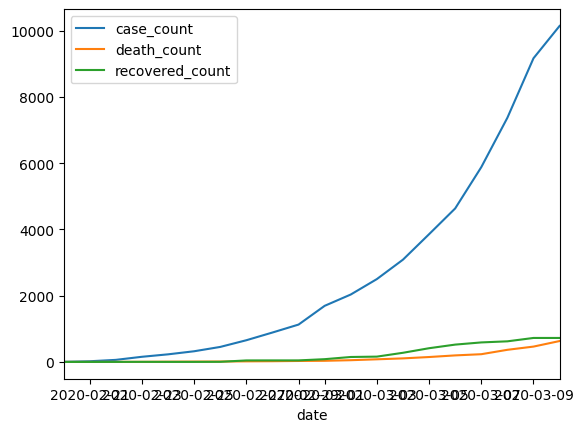

In [10]:
plot_cases_timeseries(
    it_confirmed_cases_timeseries,
    it_death_cases_timeseries,
    it_recovered_cases_timeseries,
    start_date=datetime.date(2020, 2, 20),
)

In [11]:
plot_cases_timeseries(
    us_confirmed_cases_timeseries,
    us_death_cases_timeseries,
    us_recovered_cases_timeseries,
    start_date=datetime.date(2020, 2, 22),
)

In [14]:
plot_cases_timeseries(
    ny_confirmed_cases_timeseries,
    ny_death_cases_timeseries,
    ny_recovered_cases_timeseries,
    start_date=datetime.date(2020, 3, 1),
)

In [149]:
gdf_confirmed = gpd.GeoDataFrame(
    confirmed_cases_timeseries,
    geometry=gpd.points_from_xy(
        confirmed_cases_timeseries['Long'],
        confirmed_cases_timeseries['Lat'],
))
gdf_deaths = gpd.GeoDataFrame(
    death_cases_timeseries,
    geometry=gpd.points_from_xy(
        death_cases_timeseries['Long'],
        death_cases_timeseries['Lat'],
))
gdf_recovered = gpd.GeoDataFrame(
    recovered_cases_timeseries,
    geometry=gpd.points_from_xy(
        recovered_cases_timeseries['Long'],
        recovered_cases_timeseries['Lat'],
))

3/11/20


<Figure size 1600x900 with 0 Axes>

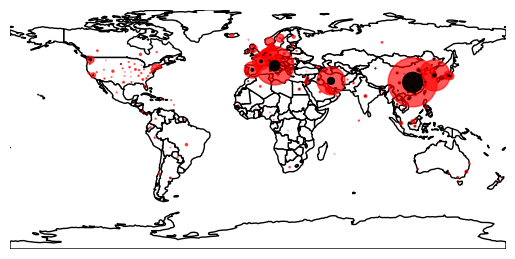

In [150]:
fig = plt.figure(figsize=(16, 9))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='black')
ax.set_axis_off()
ax.margins(0)
ax.apply_aspect()

print(latest_column_name)

gdf_confirmed.plot(ax=ax, marker='o', color='red', alpha=0.65, markersize=((gdf_confirmed[latest_column_name] - gdf_recovered[latest_column_name]) / 15))
gdf_deaths.plot(ax=ax, marker='o', color='black', alpha=0.95, markersize=(gdf_deaths[latest_column_name] / 15))

plt.show()


1/22/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

1/23/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

1/24/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

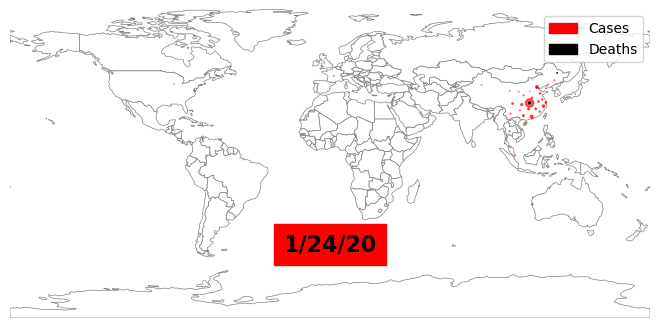

1/25/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

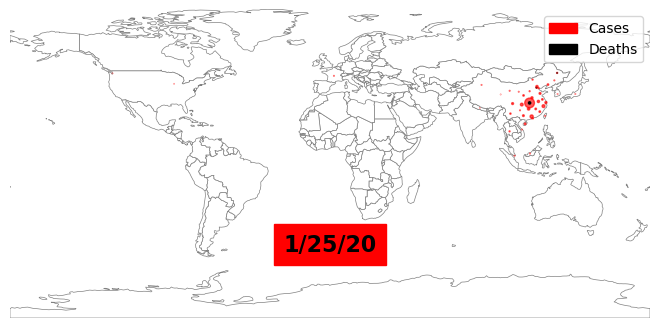

1/26/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

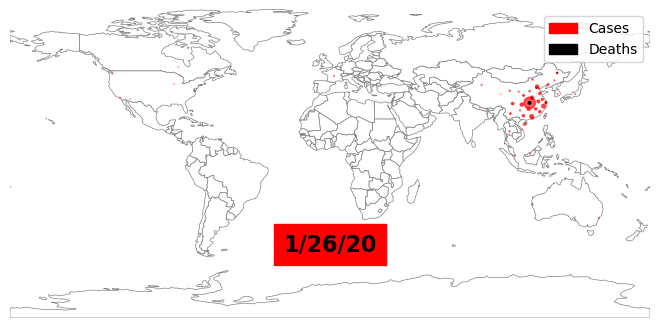

1/27/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

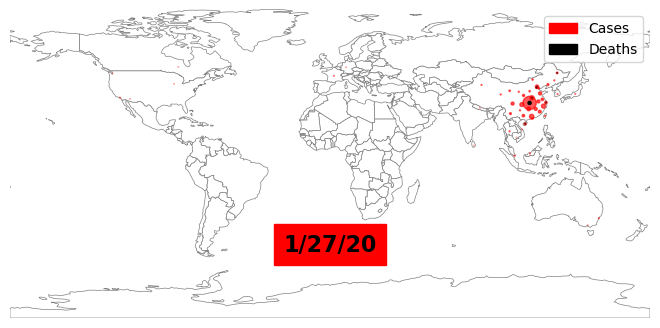

1/28/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

1/29/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

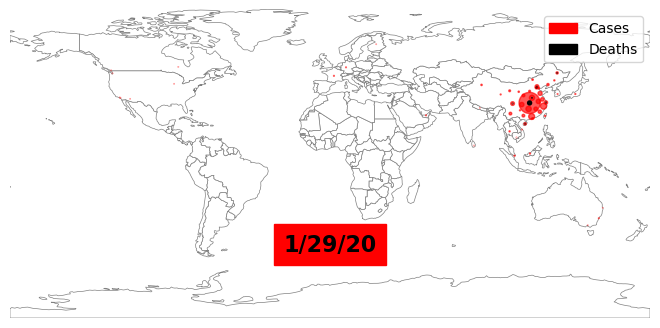

1/30/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

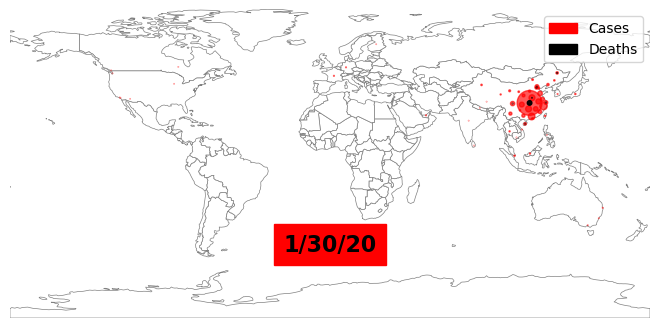

1/31/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/1/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

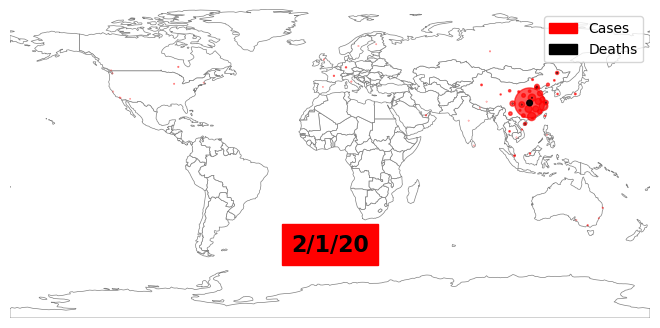

2/2/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

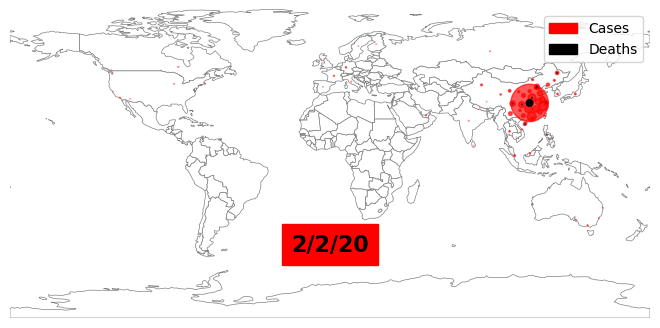

2/3/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/4/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

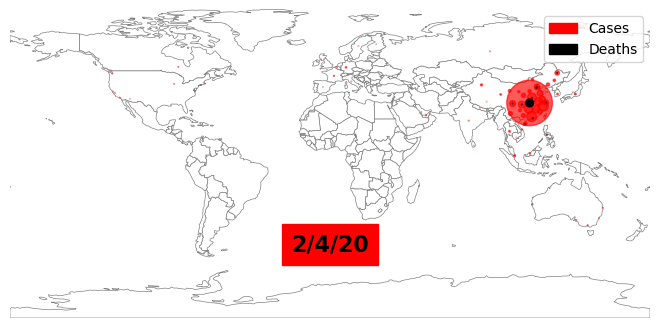

2/5/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

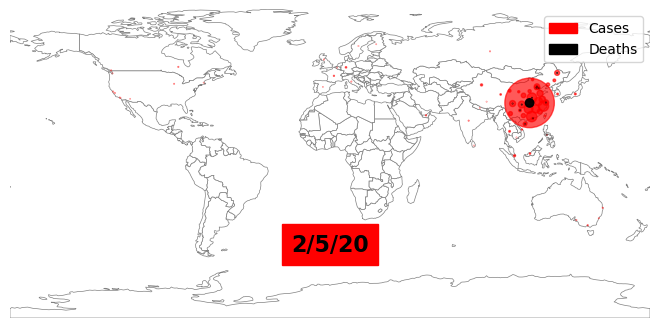

2/6/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/7/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/8/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

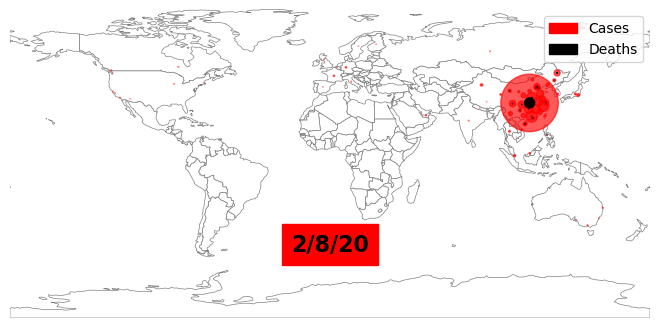

2/9/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/10/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/11/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

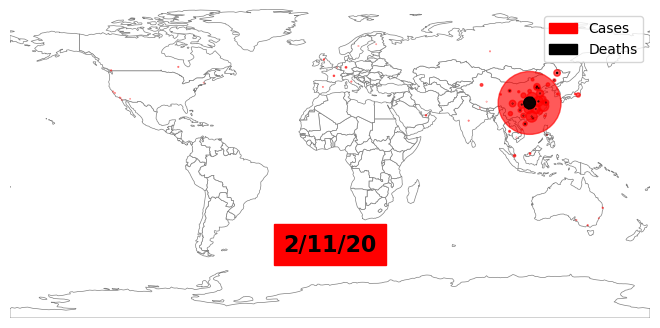

2/12/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/13/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

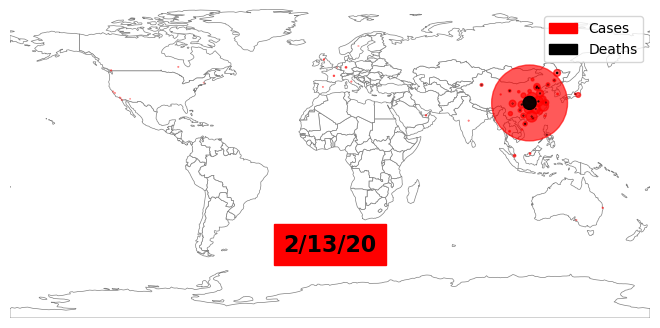

2/14/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/15/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/16/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

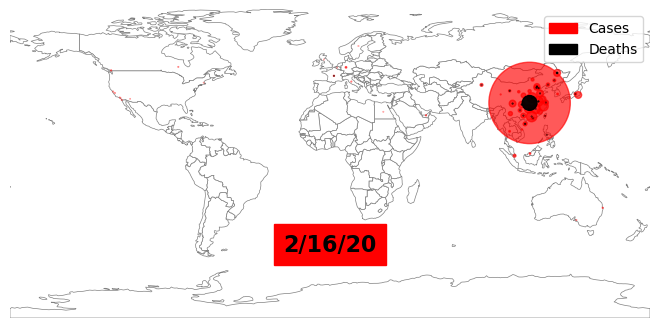

2/17/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

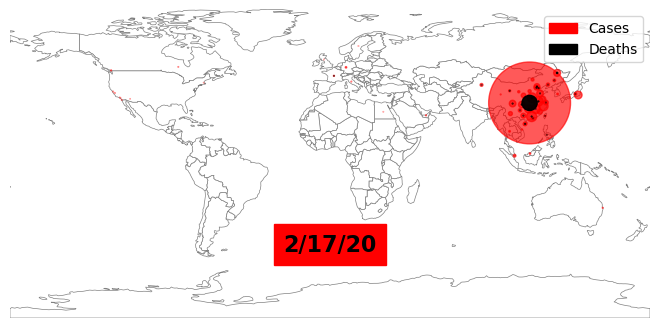

2/18/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

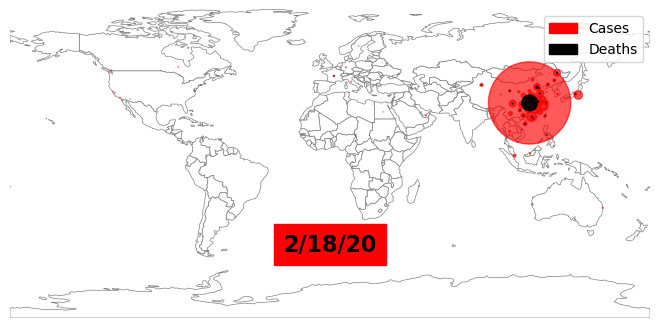

2/19/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

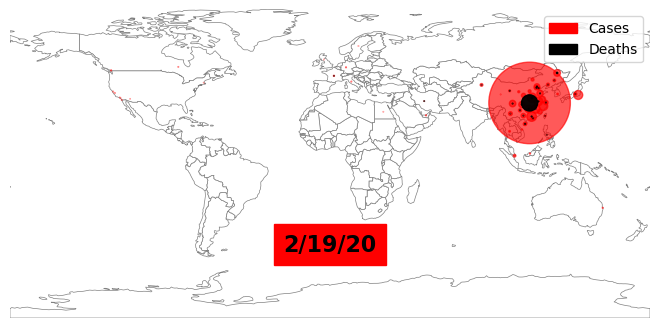

2/20/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

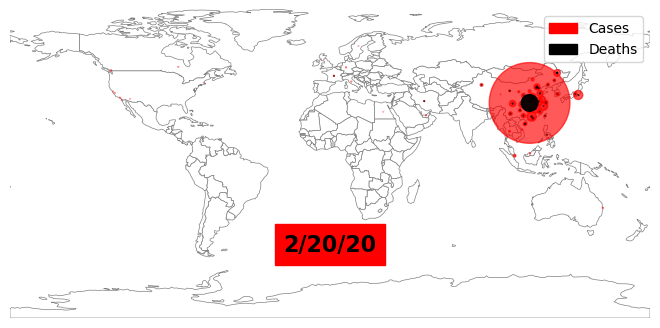

2/21/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

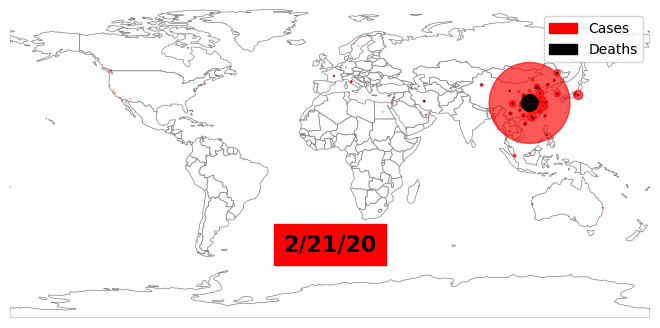

2/22/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/23/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/24/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

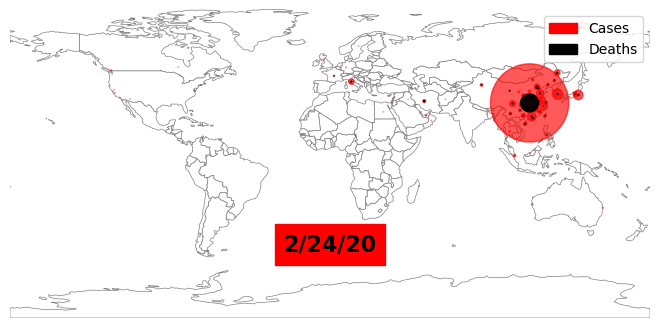

2/25/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/26/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

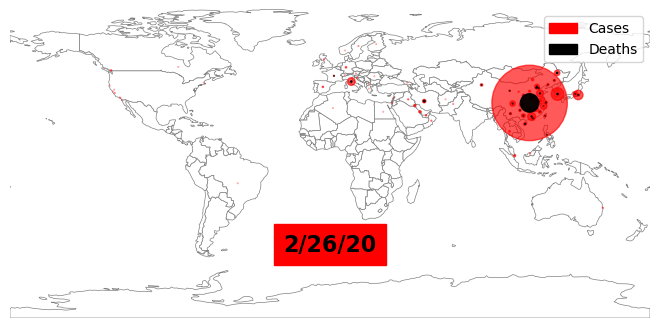

2/27/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

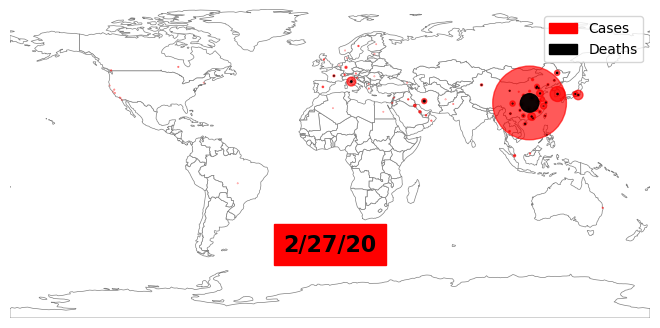

2/28/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

2/29/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

3/1/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

3/2/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

3/3/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

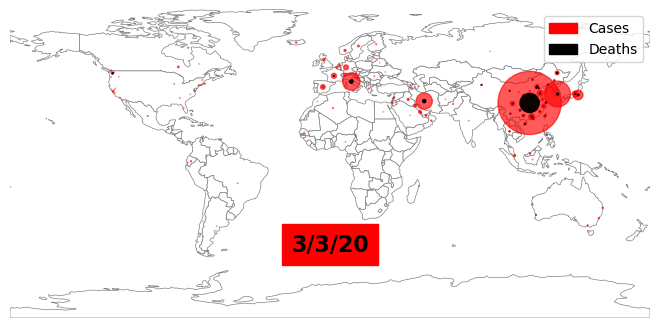

3/4/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

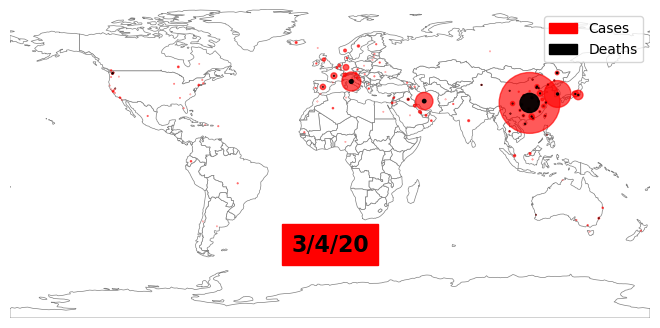

3/5/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

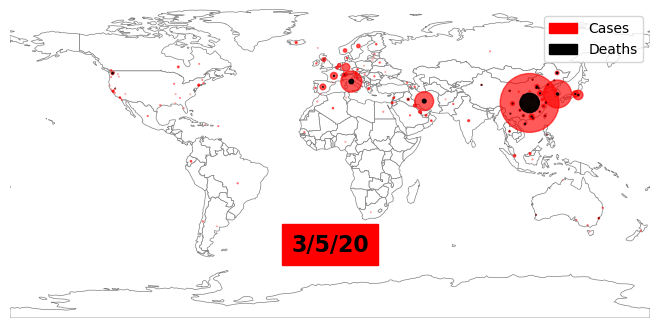

3/6/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

3/7/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

3/8/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

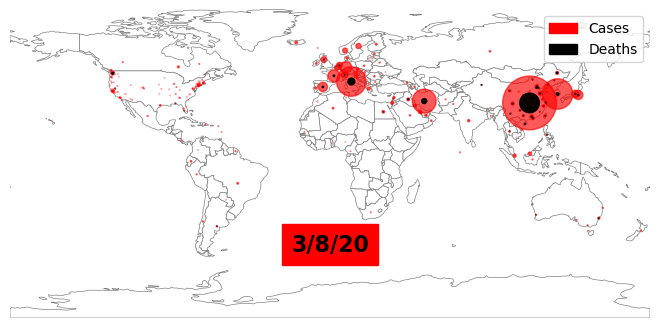

3/9/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

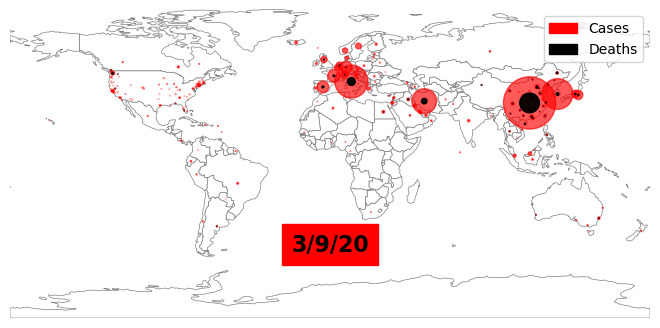

3/10/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

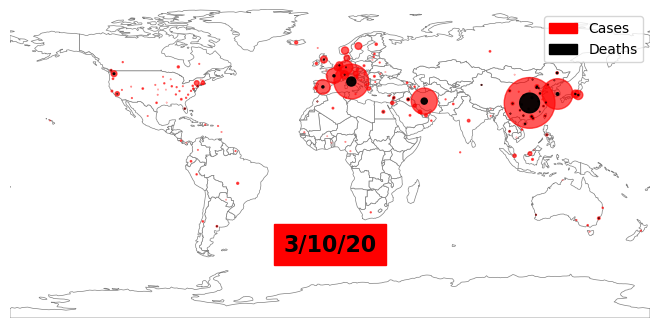

3/11/20


<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

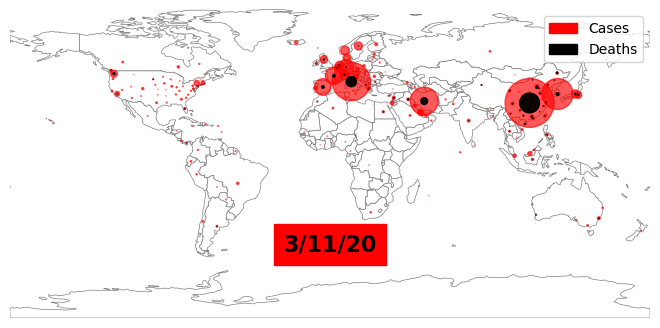

In [151]:
import io
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.patches as mpatches

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cases_patch = mpatches.Patch(color='red', label='Cases')
deaths_patch = mpatches.Patch(color='black', label='Deaths')

day_count = (yesterday - first_date).days + 1
for i, series_date in enumerate(first_date + datetime.timedelta(n) for n in range(day_count)):
    plt.clf()
    fig = plt.figure(figsize=(16, 9))
    
    ax = world.plot(color='white', edgecolor='grey', linewidths=0.5)
    ax.set_axis_off()
    ax.margins(0)
    ax.apply_aspect()
    
    column_name = series_date.strftime('%-m/%-d/%y')
    plt.text(0.5, 0.275, column_name, horizontalalignment='center', fontweight=600, backgroundcolor='red', verticalalignment='top', fontsize=16, transform = ax.transAxes)
    print(column_name)
    
    gdf_confirmed.plot(ax=ax, marker='o', color='red', alpha=0.65, markersize=((gdf_confirmed[column_name] - gdf_recovered[column_name]) / 15))
    gdf_deaths.plot(ax=ax, marker='o', color='black', alpha=0.95, markersize=(gdf_deaths[column_name] / 15)).figure
    
    filename = '/Users/steve/Desktop/corona_world/{}.png'.format(i)
    
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.legend(handles=[cases_patch, deaths_patch])
    plt.savefig(filename, format='png', bbox_inches = 'tight', pad_inches = 0, dpi=600)
    plt.show()

# make a video:
# ffmpeg -r 8 -f image2 -s 1920x1080 -i ~/Desktop/corona_world/%d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p test.mp4
